<h2> About the Problem </h2>
This problem is a multi label problem since each prediction is set in itself(A question can have many tags assosciated with it)
<li> This is a multi label classification hence performance measuring using standard methods like Precision, Recall, F1 score, log-loss wont work(they are for binary classification) 
<li> To measure the performance of this model we will use a Modified F1 score(The F1 score will act as a mean of precision and recall)
<li> The modified F1 score is called Mean averaged F1 score(See OneNote for details)
<li> We can also use Hamming Loss for multi label classification.
    


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

<h2> Reduce the size of the DataSet</h2>

In [2]:
df = pd.read_csv('Train.csv', header = None, skiprows= 1000,nrows=100000)
print(df.shape[0])
df.to_csv('Reduced_Train.csv')

100000


<h2> Loading data in SQLite</h2>

In [3]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 10000
    j = 0
    index_start = 1
    for df in pd.read_csv('Reduced_Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)
    

<h2> Counting number of rows </h2>

In [4]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) from data""",con)
    print("Number of rows in the database :" , '\n', num_rows['count(*)'].values[0])
    con.close()  #always close the db
    print("Time taken to count the number of rows :", datetime.now() - start)

Number of rows in the database : 
 100001
Time taken to count the number of rows : 0:00:01.306697


<h2> Checking for duplicates </h2>

In [5]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('select title,body,tags,count(*) as cnt_dup from data group by title,body,tags',con)
    con.close() #close the db
    print("Time taken to count the number of rows :", datetime.now() - start)

Time taken to count the number of rows : 0:00:04.271289


In [6]:
#The above query counts the number of time the same combination of Title,body,tags occur.
#If a column with the same combination occurs 3 times then the table will contain 1 entry of the combination with the cnt_dup =3
#Hence the number of rows will give the number of non duplicated data
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1
1,Encoding of sent data not working,"<p>I've got a little chatbox, everything's wor...",php jquery ajax encoding,1
2,"Files in Array, in Array to Tree?","<p>Using <code>C#</code>, I have created a pro...",c# visual-studio-2010 visual-studio-2008 clear...,1
3,Google Map location based on address,"<p>Im using Google Map in my application, it i...",android google-maps,1
4,How to insert custom field in typo3 Dam modul...,<p>I introduced my custom field in Dam modules...,typo3 dam,1


In [7]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 563 ( 0.5629943700563023 % )


In [8]:
# number of times each question appeared in our database
# There are 559 questions repeated twice 
df_no_dup.cnt_dup.value_counts()

1    98877
2      559
3        2
Name: cnt_dup, dtype: int64

In [9]:
start = datetime.now()
df_no_dup['tag_count'] = df_no_dup['Tags'].apply(lambda text : len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.057879


,Title,Body,Tags,cnt_dup,tag_count
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1,2
1,Encoding of sent data not working,"<p>I've got a little chatbox, everything's wor...",php jquery ajax encoding,1,4
2,"Files in Array, in Array to Tree?","<p>Using <code>C#</code>, I have created a pro...",c# visual-studio-2010 visual-studio-2008 clear...,1,4
3,Google Map location based on address,"<p>Im using Google Map in my application, it i...",android google-maps,1,2
4,How to insert custom field in typo3 Dam modul...,<p>I introduced my custom field in Dam modules...,typo3 dam,1,2


In [10]:
df_no_dup.tag_count.value_counts()

3    28552
2    26417
4    19001
1    13821
5    11647
Name: tag_count, dtype: int64

In [13]:
disk_dup = create_engine("sqlite:///train_no_dup.db")
no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
no_dup.to_sql('no_dup_train',disk_dup)

ValueError: Table 'no_dup_train' already exists.

In [14]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()
    tag_data.drop(tag_data.index[0],inplace =True)
    #The above removes the 1st column from tag_data. The first column is the index column which stores the index
    print(tag_data.head())
    print("\n time taken to execute this operation: ",datetime.now()-start)

                                                Tags
1                           php jquery ajax encoding
2  c# visual-studio-2010 visual-studio-2008 clear...
3                                android google-maps
4                                          typo3 dam
5                                       python regex

 time taken to execute this operation:  0:00:03.238107


<h2> Analysis of Tags </h2>

In [15]:
#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x : x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [16]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])
# The structure of the vector is : Tag1 Tag2 ....Tagn
#                                   1    0        1
# The above is not the exact representation but just a small example

Number of data points : 99437
Number of unique tags : 18458


In [17]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.bash-profile', '.class-file', '.each', '.emf', '.hgtags', '.htaccess', '.htpasswd', '.mov', '.net']


In [18]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [19]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()


,Tags,Counts
0,.a,2
1,.bash-profile,1
2,.class-file,1
3,.each,6
4,.emf,2


In [41]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False,ignore_index=True)  #ignore_index will reset the index after sorting.If not used then previous index stays. 
#So the first element may have a index on 1987 etc.
tag_counts = tag_df_sorted['Counts'].values
tag_df_sorted.head()

,Tags,Counts
0,c#,7741
1,java,6746
2,php,6537
3,javascript,6102
4,android,5292


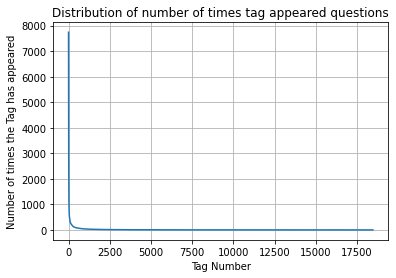

In [21]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag Number")
plt.ylabel("Number of times the Tag has appeared")
plt.show()

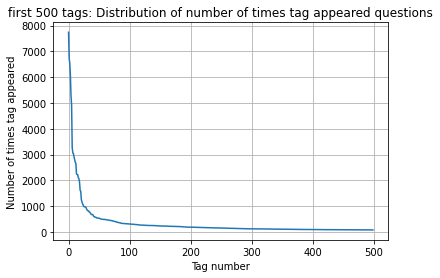

100 [7741 4923 2813 2225 1576  994  873  765  665  572  540  498  488  463
  445  411  382  357  331  322  313  300  291  276  268  264  256  255
  252  240  235  234  230  224  220  218  214  205  201  191  189  187
  183  179  174  173  168  166  162  159  157  154  149  146  143  139
  135  133  130  128  125  124  123  122  121  120  118  115  113  111
  110  109  108  106  105  104  102  100   99   98   98   97   96   94
   93   93   92   92   91   90   89   89   88   87   86   85   85   84
   83   83]


In [22]:
#Zoom in the graph for more clear obseravation
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

<li> Notice how fast the number of occurence of tags drop

In [23]:
#Storing the tags which occur more than 1000 times in on list
lst_tags_gt_1k = tag_df[tag_df.Counts>1000].Tags
print ('{} Tags are used more than 1000 times'.format(len(lst_tags_gt_1k)))

25 Tags are used more than 1000 times


In [24]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()  #the vectorizer version
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 99437 datapoints.
[4, 4, 2, 2, 2]


In [25]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.881704


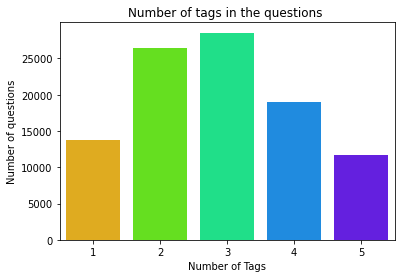

In [26]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

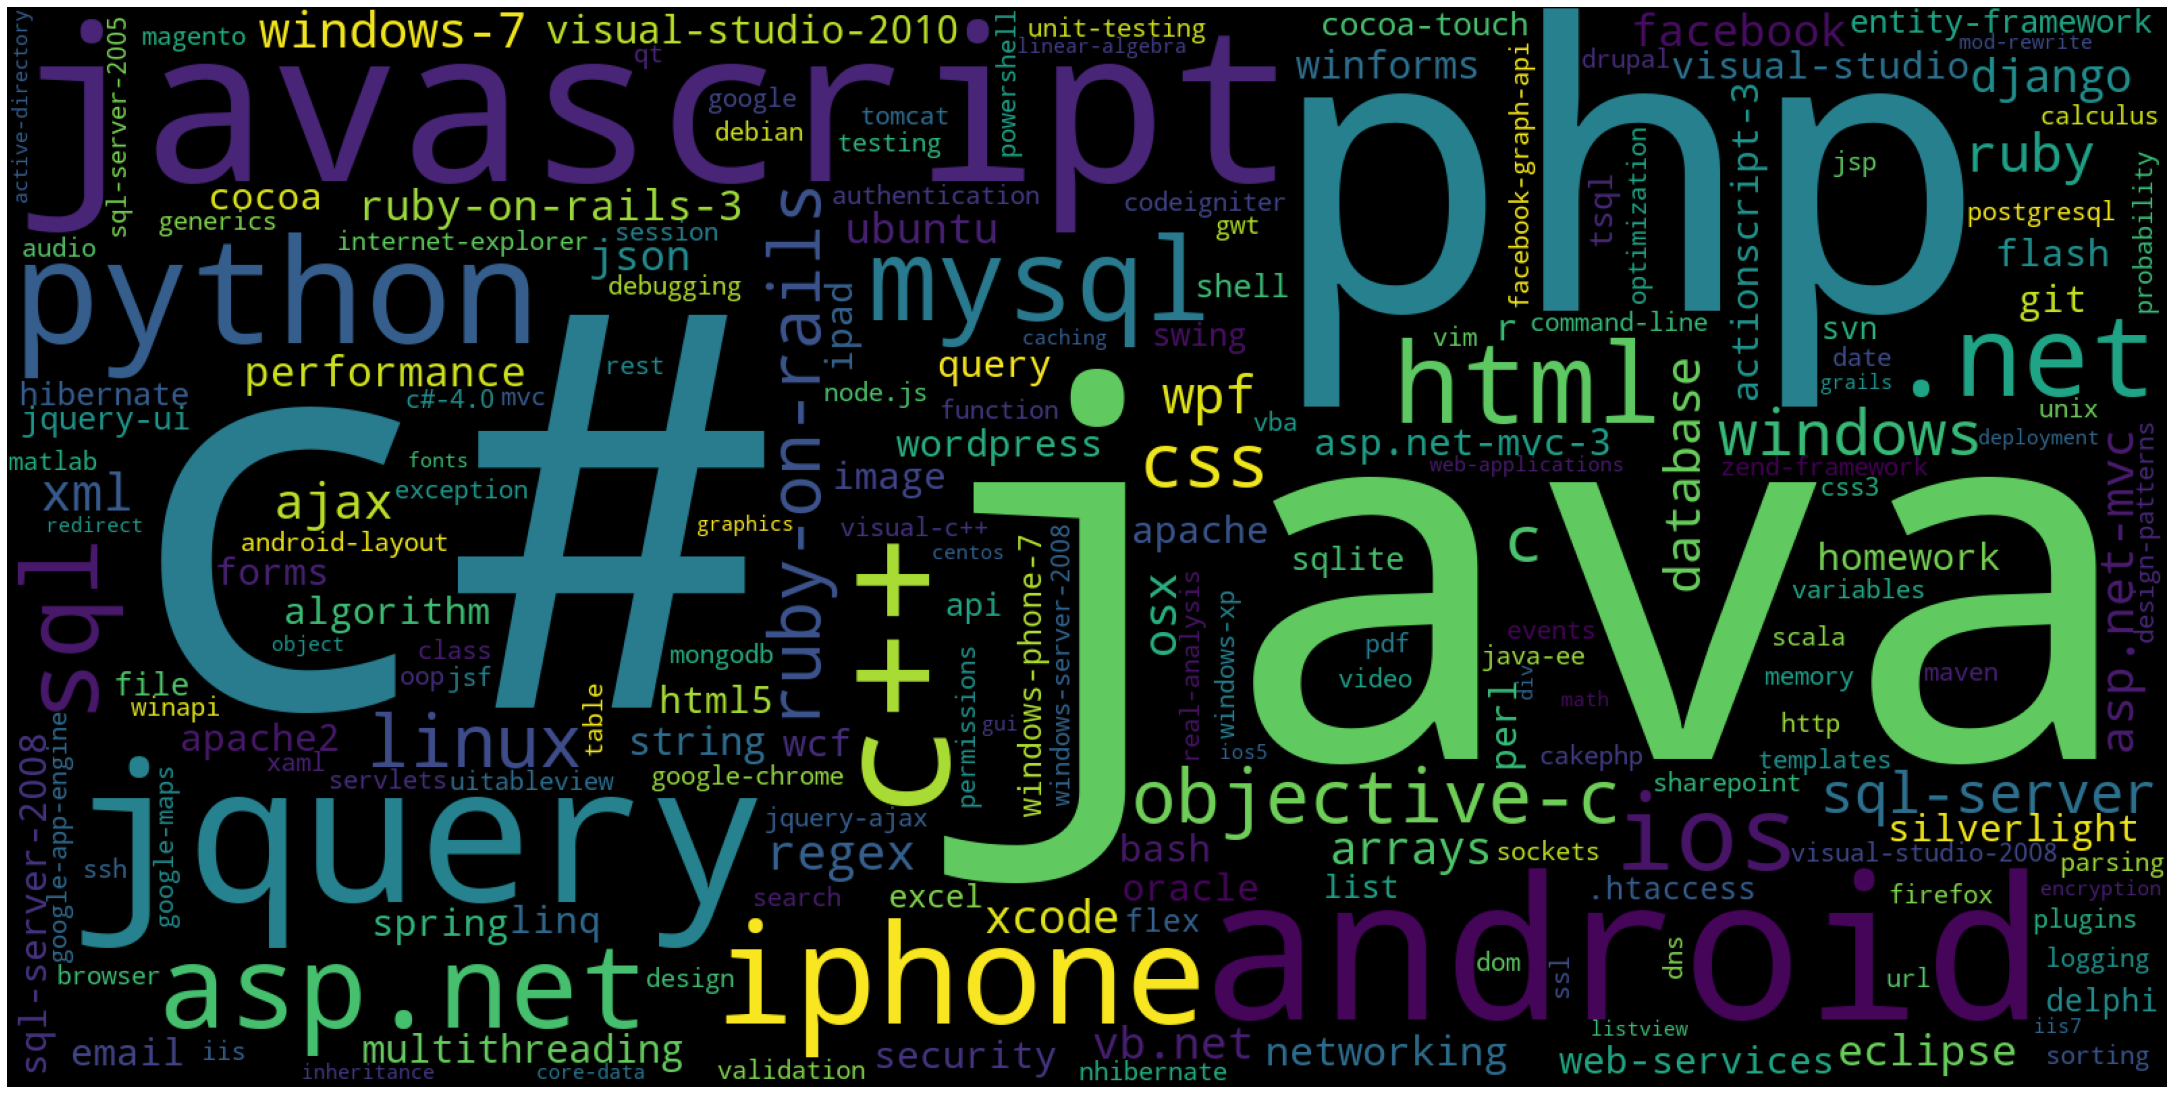

Time taken to run this cell : 0:00:03.835158


In [27]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<h2> Top 30 Tags</h2>

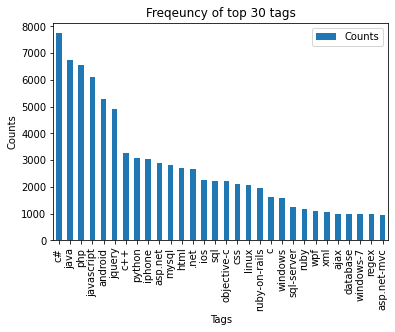

In [40]:
i=np.arange(30).tolist() #array of numbers from 0 to 29
tag_df_sorted.head(30).plot(kind = 'bar') # tag_df_sorted contains all the tags with there frequency in descending order
plt.title('Freqeuncy of top 30 tags')
plt.xticks(i,tag_df_sorted['Tags'].head(30))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<h1> Cleaning and Processing of Text</h1>

<h3> Preprocessing</h3>
<ol>
    <li> Separate out code snippets from the body</li>
    <li> Remove special characters from queston title and description and not the code</li>
    <li> Remove stop words(Except C)</li>
    <li> Remove HTML tags</li>
    <li> Convert all the characters into small letters</li>
    <li> Stem the words</li>
</ol>

In [5]:
def striphtml(data):
    cleanr = re.compile('<.*?>') #pattern matchin for html tags
    # see stack overflow for more clarification
    cleantext = re.sub(cleanr, ' ',str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english') # snowballstemmer is another way to find stem words.


In [4]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error:
        print(Error)
    return None

def create_table(conn,create_table_sql):
    try:
        c=conn.cursor() # cursor is also used to interact with database
        c.execute(create_table_sql)
    except Error:
        print(Error)

def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'" 
    # the above query is to find all the tables in the database
    table_names = cursr.execute(str)
    print("Tables in the database : ")
    tables = table_names.fetchall()
    print(tables[0][0])
    return(len(tables))

def create_database_table(database,query):
    conn =create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
        conn.close()


In [6]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the database : 
QuestionsProcessed


<h4> We clear all the rows of process db to store completely new processed data </h4>

In [8]:
start =datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    print("databse found")
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() ;")
        print("connection created")
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)   

databse found
connection created
Tables in the database : 
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:00:00.781436


In [9]:
if os.path.isfile(read_db):
    start = datetime.now()
    con = sqlite3.connect(read_db)
    checkTableExists(con)
    num_rows = pd.read_sql_query("""SELECT count(*) from no_dup_train""",con)
    print("Number of rows in the database :" , '\n', num_rows['count(*)'].values[0])
    con.close()  #always close the db
    print("Time taken to count the number of rows :", datetime.now() - start)

Tables in the database : 
no_dup_train
Number of rows in the database : 
 99438
Time taken to count the number of rows : 0:00:00.006984


In [10]:

start = datetime.now()
preprocessed_data_list = []
reader.fetchone() #fetches one row if available
questions_with_code = 0
len_pre = 0
len_post = 0
questions_processed = 0

for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], row[2]
    
    # see the questions if code is present then it is marked 
    # using <code>......</code>
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question) +len(title)
    len_pre+=x
        
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
        
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
        
    title = title.encode('utf-8')
        
    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words = word_tokenize(str(question.lower()))
    # ^[a-zA-Z] means any a-z or A-Z at the start of a line
    # [^a-zA-Z] means any character that IS NOT a-z OR A-Z
    # adding + at the end means one or more so no empty strings are choosen
    # adding * at the end would mean empty strings are also considered
        
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
        
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_processed+=1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
        
    if (questions_processed%10000==0):
        print("number of questions completed=",questions_processed)
            
no_dup_avg_len_pre=(len_pre*1.0)/questions_processed
no_dup_avg_len_post=(len_post*1.0)/questions_processed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))

print("Time taken to run this cell :", datetime.now() - start)       

number of questions completed= 10000
number of questions completed= 20000
number of questions completed= 30000
number of questions completed= 40000
number of questions completed= 50000
number of questions completed= 60000
number of questions completed= 70000
number of questions completed= 80000
number of questions completed= 90000
Avg. length of questions(Title+Body) before processing: 1150
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 56
Time taken to run this cell : 0:02:07.096036


In [11]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [4]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = sqlite3.connect(write_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("Select question from QuestionsProcessed LIMIT 10")
        print("Questions after Preprocessing")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
        conn_r.commit()
        conn_r.close()

Questions after Preprocessing
('fee remind databas design small websit user regist pay month fee want send auto remind email day membership expir design databas right tabl memberdetail paymentdetail paymentdetail tabl keep record payment made tabl someon pay membership fee also insert renew date pleas help send auto email daili use asp net amp databas design ok regard',)
----------------------------------------------------------------------------------------------------
('php instanceof fail class constant work framework tri type strong possibl work within php take idea like c tri util within framework creat collect class collect domain entiti object kinda model object net run obstacl prevent type class usercollect allow user object postcollect allow post object collect framework need certain basic function add remov iter creat interfac found follow broke complianc interfac interfac strong type collect type attempt follow attempt run code get statement littl research issu look like roo

<h4> Taking the points and putting it in a dataframe</h4>

In [4]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = sqlite3.connect(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [5]:
preprocessed_data.head()

,question,tags
0,sql return count row separ criteria need mayb ...,mysql count group
1,fee remind databas design small websit user re...,asp.net sql-server
2,php instanceof fail class constant work framew...,php oop strong-typing
3,add servlet api pom xml add servlet api projec...,java maven-2 servlets pom.xml
4,set environ variabl fetch valu run time need s...,java unix environment


In [6]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 99437
number of dimensions : 2


<h1> Machine Learning Models</h1>

<h3> Converting tags for multilable problems</h3>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [7]:
# binary ='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(),binary ='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

<h5> We have to sample the number of tags because we have a large amount of tags. So converting it to binary fromat and then training will take a lot of time</h5>
<ol>
    <li> rather then using thousands of tags, we select few tags which will cover almost every questions.</li>
    <li> The best way to do this is by taking the tags of questions with max tags.</li>
    <li> The questions which do not have any tag after this processing is deleted</li>

In [16]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)),key =lambda i:t[i],reverse = True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [9]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
count=0;
for i in range(500,total_tags,34):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))
    count+=1
print(count)

529


C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


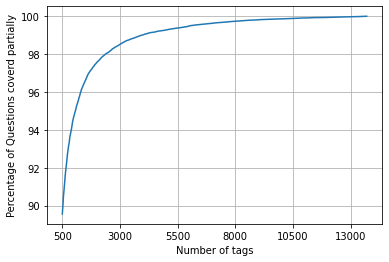

with  5500 tags we are covering  97.169 % of questions


In [10]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Percentage of Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [25]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 911 out of  99437


In [26]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")
print("We have considered top 30% of the tags")

Number of tags in sample : 18458
number of tags taken : 5500 ( 29.797377830750893 %)
We have considered top 30% of the tags


<h2> Spliting the data into test and train(80 - 20)</h2> 

In [27]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80 * total_size)

x_train = preprocessed_data.head(train_size)
X_test = preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [28]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (79549, 5500)
Number of data points in test data : (19888, 5500)


<h2> Featurizing data</h2>

<h4> TFIDF vectorizer</h4>

In [29]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3)) #n-gram 1,2 and 3
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:33.166002


In [30]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (79549, 89199) Y : (79549, 5500)
Dimensions of test data X: (19888, 89199) Y: (19888, 5500)


<h4> Remember we did not use any multilable classifier(since very resource hungary like MLKNN it uses dense matrix rather than sparce matrix and while using TFIDF we converted our data to sparce matrix), rather we converted the data for normal classification algo</h4>

<h3> Note</h3>
<li> If try to traing our model now then it might take a lot of time to train <li>
<li> To reduce the time we need to take less number of tags in consideration<li>
<li> Also and important thing to keep in mind is that to heading of the question contains the max amount of information. In many cases just from the heading the tags can be predicted<li>
<li> We need to give more significance to heading. May be 3 times more significance.
<li> The best way to give 3 times significance to heading is by repeating the heading 3 times in the text vector. 
<li> We need to do same operations we did above to make the above change.
    

<h2> Sampling 1 lakh points</h2>

In [6]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the database : 
QuestionsProcessed


In [7]:
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 80000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 100001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 100001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the database : 
QuestionsProcessed
Cleared All the rows


<h2> Preprocessing of data</h2>

In [8]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%10000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 10000
number of questions completed= 20000
number of questions completed= 30000
number of questions completed= 40000
number of questions completed= 50000
number of questions completed= 60000
number of questions completed= 70000
number of questions completed= 80000
number of questions completed= 90000
Avg. length of questions(Title+Body) before processing: 1150
Avg. length of questions(Title+Body) after processing: 409
Percent of questions containing code: 56
Time taken to run this cell : 0:03:19.076335


In [9]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [10]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('file array array tree file array array tree file array array tree use creat program execut command line captur output text file output huge pain figur isnt much way document clearcas plugin anyhow would like skip file use output consol ... output appear like want basic load tree appear directori list ... could sortabl easi tell latest version particular file directori one problem multipl instanc directori file version particular file count may differ branch version ... troubl slight experienc quit comprehend load array array neat go keep associ onlin exampl tree view find hard code string dynam string anyon experi know trick cant decid visual studio line edit best use split directori use ... later point get figur want re-send data clearcas via command prompt auto checkout associ file ... part seem easier point view ... post code close loop lan exampl treeview scratch head dotnetperl array tree d.morton msdn',)
---------------------------------------------

In [11]:
#Taking 1 lakh entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [12]:
preprocessed_data.head()

,question,tags
0,encod sent data work encod sent data work enco...,php jquery ajax encoding
1,file array array tree file array array tree fi...,c# visual-studio-2010 visual-studio-2008 clear...
2,googl map locat base address googl map locat b...,android google-maps
3,insert custom field typo3 dam modul custom loc...,typo3 dam
4,preserv case use re.ignorecas .sub preserv cas...,python regex


In [13]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 99437
number of dimensions : 2


In [14]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [17]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


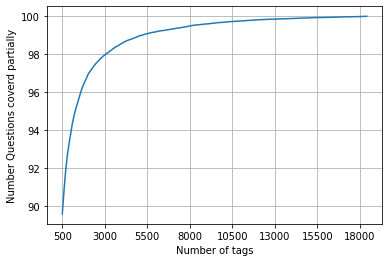

with  5500 tags we are covering  99.084 % of questions
with  500 tags we are covering  89.565 % of questions


In [18]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [32]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 10376 out of  99437


In [36]:
total_datasize = preprocessed_data.shape[0]
train_datasize = (int)(total_datasize*0.80)

x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [37]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (79549, 500)
Number of data points in test data : (19888, 500)


<h3> Featurizing data with TfIdf vectorizer </h3>

In [38]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:40.901074


In [39]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (79549, 89375) Y : (79549, 500)
Dimensions of test data X: (19888, 89375) Y: (19888, 500)


<h2> Logistic Regression with OnevsRest Classifier</h2>

In [41]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(C=1, penalty='l1', solver='liblinear'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.24316170555108607
Hamming loss  0.0027329042638777152
Micro-average quality numbers
Precision: 0.7105, Recall: 0.3818, F1-measure: 0.4967
Macro-average quality numbers
Precision: 0.5526, Recall: 0.2833, F1-measure: 0.3570
              precision    recall  f1-score   support

           0       0.65      0.30      0.41      1203
           1       0.79      0.42      0.55      1219
           2       0.81      0.52      0.63      1535
           3       0.69      0.42      0.52      1474
           4       0.93      0.70      0.80       968
           5       0.89      0.74      0.81      1742
           6       0.81      0.46      0.58       729
           7       0.89      0.58      0.70       646
           8       0.78      0.55      0.64       853
           9       0.82      0.39      0.53       527
          10       0.84      0.57      0.68       565
          11       0.50      0.19      0.28       627
          12       0.67      0.16      0.26       342
        

C:\Users\RISHAB MALLICK\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RISHAB MALLICK\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RISHAB MALLICK\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 